# Assingment 1 - Malaria Cell Image Classification
### Course: Convolutional Neural Networks with Applications in Medical Image Analysis

Office hours: Mondays 13.15--15.00 (Tommy), Tuesdays 13.15--16.00 (Minh), Thursdays 08.15--12.00 (Attila)

Welcome. The first assignment is based on classifying images of cells, whether they are parasitized or uninfected by malaria. Your input will be an image of a cell, and your output is a binary classifier. It is based on an open dataset, available from Lister Hill National Center for Biomedical Communications (NIH): https://lhncbc.nlm.nih.gov/publication/pub9932. You need to download the file ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Malaria/cell_images.zip (as described in the assignment instructions). The data was preprocessed and organized for easier machine learning applications.

Your task is to look through the highly customizable code below, which contains all the main steps for high accuracy classification of these data, and improve upon the model. The most important issues with the current code are noted in the comments for easier comprehension. Your tasks, to include in the report, are:

- Reach an accuracy of at least 96~\% on the validation dataset.
- Plot the training/validating losses and accuracies. Describe when to stop training, and why that is a good choice.
- Describe the thought process behind building your model and choosing the model hyper-parameters.
- Describe what you think are the biggest issues with the current setup, and how to solve them.

In [1]:
# Import necessary packages for loading the dataset

import numpy as np  # Package for matrix operations, handling data
np.random.seed(2020)
import os
import cv2
import matplotlib.pyplot as plt  # Package for plotting
#from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
import tensorflow.keras as keras

# Path to dataset downloaded from the provided link
data_path = "cell_images"  # Path to dataset

In [2]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self,
                 data_path,
                 inputs,
                 outputs,
                 batch_size=32
                 ):

        self.data_path = data_path
        self.inputs = inputs
        self.outputs = outputs
        self.batch_size = batch_size

        if data_path is None:
            raise ValueError('The data path is not defined.')

        if not os.path.isdir(data_path):
            raise ValueError('The data path is incorrectly defined.')

        self.file_idx = 0
        self.file_list = [self.data_path + '/' + s for s in
                          os.listdir(self.data_path)]
        
        self.on_epoch_end()
        with np.load(self.file_list[0]) as npzfile:
            self.out_dims = []
            self.in_dims = []
            self.n_channels = 1
            for i in range(len(self.inputs)):
                im = npzfile[self.inputs[i]]
                self.in_dims.append((self.batch_size,
                                    *np.shape(im),
                                    self.n_channels))
            for i in range(len(self.outputs)):
                im = npzfile[self.outputs[i]]
                self.out_dims.append((self.batch_size,
                                        *np.shape(im),
                                        self.n_channels))
            npzfile.close()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor((len(self.file_list)) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) *
                               self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.file_list[k] for k in indexes]

        # Generate data
        i, o = self.__data_generation(list_IDs_temp)
        return i, o

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.file_list))
        np.random.shuffle(self.indexes)
    
    #@threadsafe_generator
    def __data_generation(self, temp_list):
        'Generates data containing batch_size samples'
        # X : (n_samples, *dim, n_channels)
        # Initialization
        inputs = []
        outputs = []

        for i in range(self.inputs.__len__()):
            inputs.append(np.empty(self.in_dims[i]).astype(np.single))

        for i in range(self.outputs.__len__()):
            outputs.append(np.empty(self.out_dims[i]).astype(np.single))

        for i, ID in enumerate(temp_list):
            with np.load(ID) as npzfile:
                for idx in range(len(self.inputs)):
                    x = npzfile[self.inputs[idx]] \
                        .astype(np.single)
                    x = np.expand_dims(x, axis=2)
                    inputs[idx][i, ] = x

                for idx in range(len(self.outputs)):
                    x = npzfile[self.outputs[idx]] \
                        .astype(np.single)
                    x = np.expand_dims(x, axis=2)
                    outputs[idx][i, ] = x
                npzfile.close()

        return inputs, outputs


In [3]:
gen_dir = '/mnt/4a39cb60-7f1f-4651-81cb-029245d590eb/DS0042_brats/'
# Available arrays in data: 'flair', 't1', 't2', 't1ce', 'mask'
# See the lab instructions for more info about the arrays
input_arrays = ['flair', 't1', 't1ce']# ['flair', 't1', 't1ce']
output_arrays = ['mask']
batch_size = 128
gen_train = DataGenerator(data_path = gen_dir+'training',
                    inputs=input_arrays,
                    outputs=output_arrays,
                    batch_size=batch_size)

gen_test = DataGenerator(data_path = gen_dir+'testing',
                    inputs=input_arrays,
                    outputs=output_arrays,
                    batch_size=batch_size)

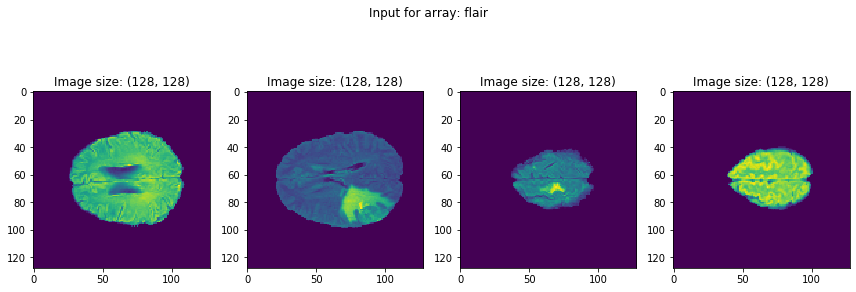

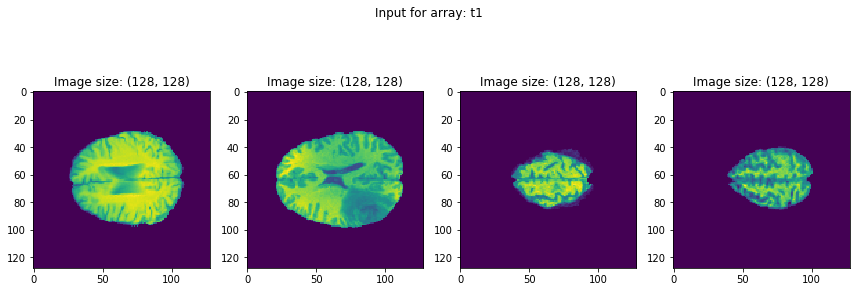

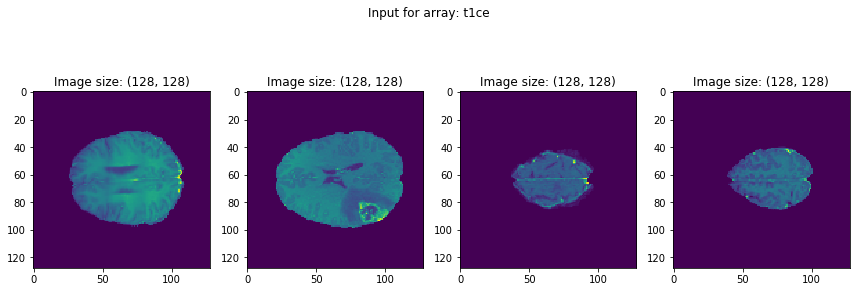

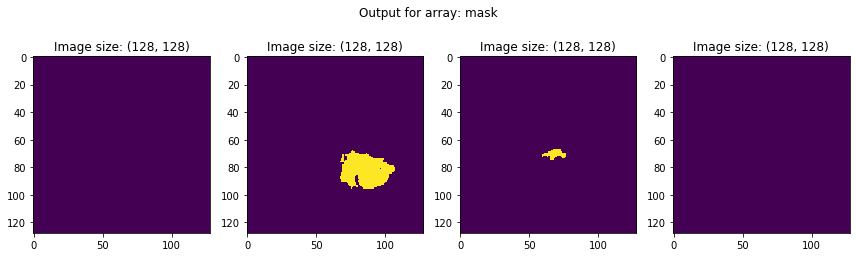

In [4]:
# Look at some sample images
img_in, img_out = gen_train.__getitem__(0)#np.random.randint(0, gen_train.__len__()))
for inp in range(np.shape(img_in)[0]):
    plt.figure(figsize=(12,5))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.imshow(img_in[inp][i, :, :, 0])
        plt.title('Image size: ' + str(np.shape(img_in[inp][i, :, :, 0])))
        plt.tight_layout()
    plt.suptitle('Input for array: ' + gen_train.inputs[inp])
    plt.show()

plt.figure(figsize=(12,4))
for outp in range(np.shape(img_out)[0]):
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.imshow(img_out[outp][i, :, :, 0])
        plt.title('Image size: ' + str(np.shape(img_out[outp][i, :, :, 0])))
        plt.tight_layout()

    plt.suptitle('Output for array: ' + gen_train.outputs[outp])
    plt.show()

# NOTE: The images are of different size. Also they are RGB images.

In [5]:
np.random.randint(low=1, high=90, size=5)

array([45, 53, 12, 33,  4])

### The dataset preprocessing so far has been to help you, you should not change anything. However, from now on, take nothing for granted.

In [6]:
# A quick summary of the data:
print(f"Number of training images  : {str(len(gen_train.file_list))}")
#print(f"Validation image size: {str(x_val.shape)}")
#print(f"Testing image size   : {str(x_test.shape)}")
#print("")
print(f"Training batch size: {str(gen_train.in_dims)}")
#print(f"Validating label size: {str(y_val.shape)}")
#print(f"Testing label size   : {str(y_test.shape)}")

Number of training images  : 8000
Training batch size: [(128, 128, 128, 1), (128, 128, 128, 1), (128, 128, 128, 1)]


In [7]:
# Import packages important for building and training your model.

import tensorflow.keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.layers import Flatten, Input
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout, UpSampling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers

In [9]:
def build_model(height, width, channels):
    input_1 = Input(shape=(height, width, channels), name='input_1')
    input_2 = Input(shape=(height, width, channels), name='input_2')
    input_3 = Input(shape=(height, width, channels), name='input_3')
    inputs = Concatenate(axis=-1)([input_1, input_2, input_3])
    filt = 24
    dp = 0.3
    
    conv1 = Conv2D(filt, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(filt, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(filt*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(filt*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(filt*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(filt*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(filt*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(filt*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(dp)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(filt*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(filt*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(dp)(conv5)

    up6 = Conv2D(filt*8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = Concatenate(axis=-1)([drop4,up6])
    conv6 = Conv2D(filt*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(filt*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Dropout(dp)(conv6)

    up7 = Conv2D(filt*4, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = Concatenate(axis=-1)([conv3,up7])
    conv7 = Conv2D(filt*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(filt*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Dropout(dp)(conv7)

    up8 = Conv2D(filt*2, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = Concatenate(axis=-1)([conv2,up8])
    conv8 = Conv2D(filt*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(filt*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Dropout(dp)(conv8)

    up9 = Conv2D(filt, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = Concatenate(axis=-1)([conv1,up9])
    conv9 = Conv2D(filt, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(filt, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = BatchNormalization()(conv9)
    #conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    output_1 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    return Model(inputs=[input_1, input_2, input_3], outputs=[output_1])

In [13]:
# Build your model.

height, width, channels = gen_train.in_dims[0][1:]
model = build_model(height=height, width=width, channels=channels)
model.summary()

# NOTE: Are the input sizes correct?
# NOTE: Are the output sizes correct?
# NOTE: Is the 'hotmap' activation layer in the model?
# NOTE: Try to imagine the model layer-by-layer and think it through. Is it doing something reasonable?
# NOTE: Are the model parameters split "evenly" between the layers? Or is there one huge layer?
# NOTE: Will the model fit into memory? Is the model too small? Is the model too large?

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 128, 128, 3)  0           input_1[0][0]                    
                                                                 input_2[0][0]              

In [14]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return -K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

# Compile the model, try out different optimizers
learning_rate = 0.002
optim = optimizers.RMSprop(lr=learning_rate)
model.compile(loss=dice_coef,
              optimizer=optim,
              metrics=[dice_coef])

# NOTE: Are you satisfied with the loss function?
# NOTE: Are you satisfied with the metric?
# NOTE: Are you satisfied with the optimizer and its parameters?

In [15]:
#fit the model onto the dataset
n_epochs = 300
h = model.fit_generator(gen_train, 
                        epochs=n_epochs,
                        max_queue_size=4,
                        workers=4,
                        use_multiprocessing=False,
                        validation_data=gen_test)

# NOTE: Plotting the accuracies and losses helps a lot.
# NOTE: What does plotting the training data tell you? Should you plot something else?
# NOTE: What should one do with the validation data?
# NOTE: When should one stop? Did you overtrain? Did you train for long enough?
# NOTE: Think about implementing Early Stopping?

Epoch 1/300
62/62 [==============================] - 36s 581ms/step - loss: -0.2461 - dice_coef: -0.2461 - val_loss: -0.0187 - val_dice_coef: -0.0187
Epoch 2/300
62/62 [==============================] - 36s 577ms/step - loss: -0.3819 - dice_coef: -0.3819 - val_loss: -0.4979 - val_dice_coef: -0.4979
Epoch 3/300
62/62 [==============================] - 36s 577ms/step - loss: -0.5191 - dice_coef: -0.5191 - val_loss: -0.4920 - val_dice_coef: -0.4920
Epoch 4/300
62/62 [==============================] - 35s 559ms/step - loss: -0.5291 - dice_coef: -0.5291 - val_loss: -0.4478 - val_dice_coef: -0.4478
Epoch 5/300
62/62 [==============================] - 35s 563ms/step - loss: -0.5314 - dice_coef: -0.5314 - val_loss: -0.0417 - val_dice_coef: -0.0417
Epoch 6/300
62/62 [==============================] - 35s 564ms/step - loss: -0.6626 - dice_coef: -0.6626 - val_loss: -0.6160 - val_dice_coef: -0.6160
Epoch 7/300
62/62 [==============================] - 34s 552ms/step - loss: -0.6897 - dice_coef: -0.

62/62 [==============================] - 35s 556ms/step - loss: -0.8739 - dice_coef: -0.8739 - val_loss: -0.7439 - val_dice_coef: -0.7439
Epoch 110/300
62/62 [==============================] - 35s 557ms/step - loss: -0.8806 - dice_coef: -0.8806 - val_loss: -0.7722 - val_dice_coef: -0.7722
Epoch 111/300
62/62 [==============================] - 35s 558ms/step - loss: -0.8765 - dice_coef: -0.8765 - val_loss: -0.7844 - val_dice_coef: -0.7844
Epoch 112/300
62/62 [==============================] - 36s 585ms/step - loss: -0.8748 - dice_coef: -0.8748 - val_loss: -0.7440 - val_dice_coef: -0.7440
Epoch 113/300
62/62 [==============================] - 37s 603ms/step - loss: -0.8822 - dice_coef: -0.8822 - val_loss: -0.7754 - val_dice_coef: -0.7754
Epoch 114/300
62/62 [==============================] - 38s 612ms/step - loss: -0.8814 - dice_coef: -0.8814 - val_loss: -0.7705 - val_dice_coef: -0.7705
Epoch 115/300
62/62 [==============================] - 35s 558ms/step - loss: -0.8800 - dice_coef: -0.

Epoch 163/300
62/62 [==============================] - 35s 566ms/step - loss: -0.8902 - dice_coef: -0.8902 - val_loss: -0.7310 - val_dice_coef: -0.7310
Epoch 164/300
62/62 [==============================] - 34s 552ms/step - loss: -0.8920 - dice_coef: -0.8920 - val_loss: -0.7655 - val_dice_coef: -0.7655
Epoch 165/300
62/62 [==============================] - 34s 556ms/step - loss: -0.8937 - dice_coef: -0.8937 - val_loss: -0.7735 - val_dice_coef: -0.7735
Epoch 166/300
62/62 [==============================] - 36s 584ms/step - loss: -0.8915 - dice_coef: -0.8915 - val_loss: -0.7727 - val_dice_coef: -0.7727
Epoch 167/300
62/62 [==============================] - 35s 568ms/step - loss: -0.8805 - dice_coef: -0.8805 - val_loss: -0.7503 - val_dice_coef: -0.7503
Epoch 168/300
62/62 [==============================] - 34s 556ms/step - loss: -0.8944 - dice_coef: -0.8944 - val_loss: -0.7662 - val_dice_coef: -0.7662
Epoch 169/300
62/62 [==============================] - 36s 581ms/step - loss: -0.8952 - 

Epoch 217/300
62/62 [==============================] - 38s 605ms/step - loss: -0.9056 - dice_coef: -0.9056 - val_loss: -0.7842 - val_dice_coef: -0.7842
Epoch 218/300
62/62 [==============================] - 36s 574ms/step - loss: -0.9040 - dice_coef: -0.9040 - val_loss: -0.7666 - val_dice_coef: -0.7666
Epoch 219/300
62/62 [==============================] - 34s 548ms/step - loss: -0.9072 - dice_coef: -0.9072 - val_loss: -0.7828 - val_dice_coef: -0.7828
Epoch 220/300
62/62 [==============================] - 35s 558ms/step - loss: -0.9073 - dice_coef: -0.9073 - val_loss: -0.7853 - val_dice_coef: -0.7853
Epoch 221/300
62/62 [==============================] - 35s 565ms/step - loss: -0.9059 - dice_coef: -0.9059 - val_loss: -0.7948 - val_dice_coef: -0.7948
Epoch 222/300
62/62 [==============================] - 34s 551ms/step - loss: -0.9051 - dice_coef: -0.9051 - val_loss: -0.7709 - val_dice_coef: -0.7709
Epoch 223/300
62/62 [==============================] - 35s 557ms/step - loss: -0.9078 - 

Epoch 271/300
62/62 [==============================] - 34s 549ms/step - loss: -0.9127 - dice_coef: -0.9127 - val_loss: -0.7743 - val_dice_coef: -0.7743
Epoch 272/300
62/62 [==============================] - 36s 574ms/step - loss: -0.9124 - dice_coef: -0.9124 - val_loss: -0.7534 - val_dice_coef: -0.7534
Epoch 273/300
62/62 [==============================] - 36s 574ms/step - loss: -0.9119 - dice_coef: -0.9119 - val_loss: -0.7655 - val_dice_coef: -0.7655
Epoch 274/300
62/62 [==============================] - 34s 545ms/step - loss: -0.9134 - dice_coef: -0.9134 - val_loss: -0.7750 - val_dice_coef: -0.7750
Epoch 275/300
62/62 [==============================] - 35s 565ms/step - loss: -0.9126 - dice_coef: -0.9126 - val_loss: -0.7703 - val_dice_coef: -0.7703
Epoch 276/300
62/62 [==============================] - 35s 557ms/step - loss: -0.9102 - dice_coef: -0.9102 - val_loss: -0.7786 - val_dice_coef: -0.7786
Epoch 277/300
62/62 [==============================] - 36s 580ms/step - loss: -0.9150 - 

In [17]:
count = 0
count_pred = 0
for i in range(gen_test.__len__()):
    img_in, img_out = gen_test.__getitem__(i)
    prediction = model.predict(img_in)

    for idx in range(batch_size):
        count = count + np.max(img_out[0][idx, :, :, 0])
        count_pred = count_pred + np.max(prediction[idx, :, :, 0])

print(gen_test.__len__() * batch_size)
print(count)
print(count_pred)

960
597.0
561.9045753777027


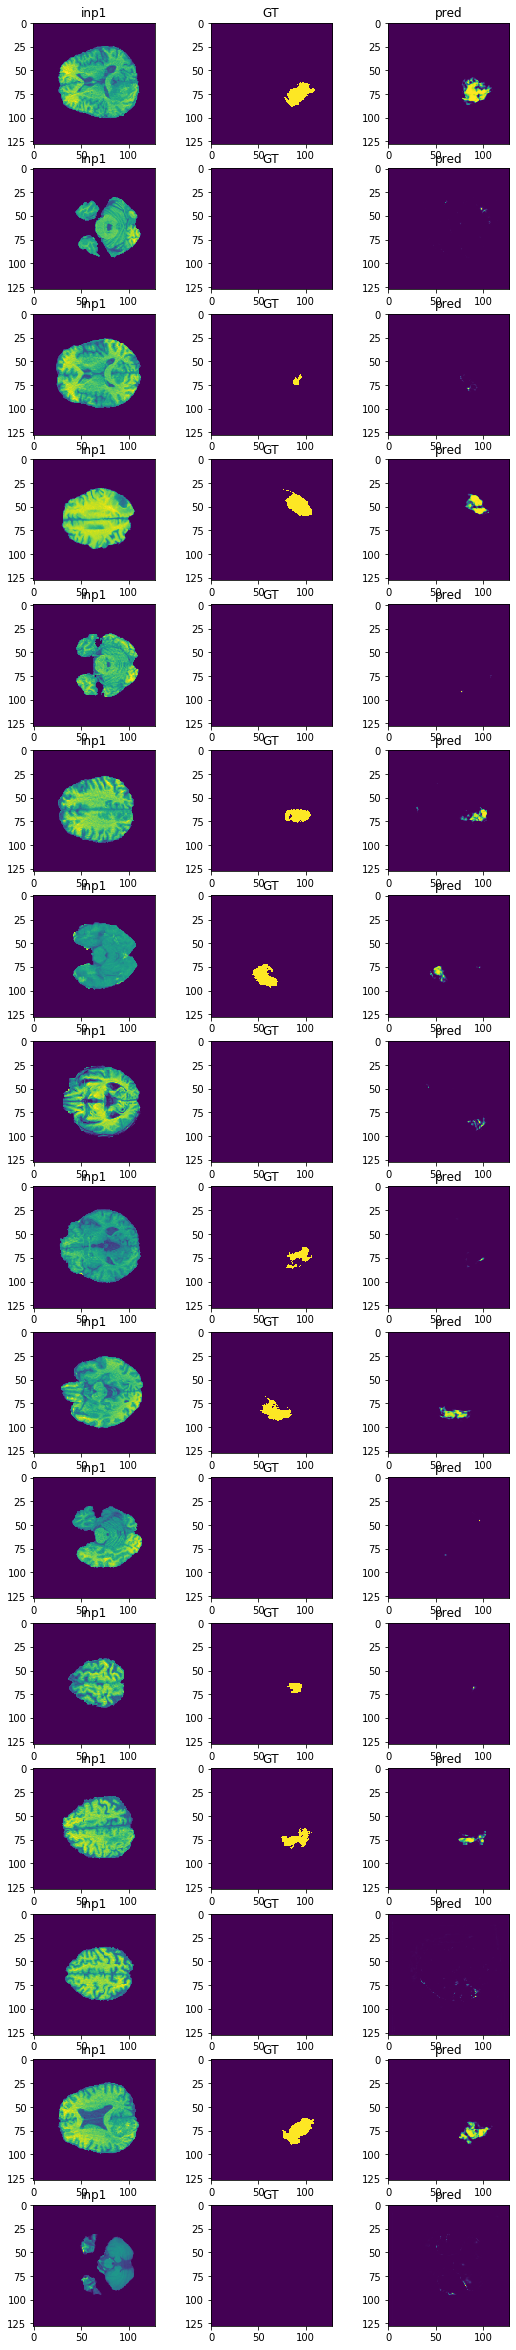

In [15]:
img_in, img_out = gen_test.__getitem__(np.random.randint(0, gen_test.__len__()))
prediction = model.predict(img_in)

plt.figure(figsize=(9,128))
for idx in range(16):
    plt.subplot(batch_size, 3, idx*3 + 1)
    plt.imshow(img_in[0][idx, :, :, 0])
    plt.title('inp1')
    #plt.subplot(batch_size, 5, idx*5 + 2)
    #plt.imshow(img_in[1][idx, :, :, 0])
    #plt.title('inp2')
    #plt.subplot(batch_size, 5, idx*5 + 3)
    #plt.imshow(img_in[2][idx, :, :, 0])
    #plt.title('inp3')
    plt.subplot(batch_size, 3, idx*3 + 2)
    plt.imshow(img_out[0][idx, :, :, 0])
    plt.title('GT')
    plt.subplot(batch_size, 3, idx*3 + 3)
    plt.imshow(prediction[idx, :, :, 0])
    plt.title('pred')
    

In [14]:
# Evaluate the model on the validation data. Its this value that should exceed 0.96 (i.e., 95 %).
if True:
    predictions = model.evaluate_generator(gen_test, verbose=0)
    print(f"Validation MSE    : {predictions[0]:.3f}")
    print(f"Validation MAE    : {predictions[1]:.3f}")

# NOTE: Is this high enough? How about varying model hyper-parameters? Perhaps implement data augmentation?

Validation MSE    : 0.054
Validation MAE    : 0.506
